<h1 align="center">Twitter Sentiment Analysis - LSTM Model Building: Deep Learning</h1>

**Welcome to Deep Learning for Sentiment Analysis!** 🚀

In this workbook, you'll learn how to build a **Long Short-Term Memory (LSTM)** neural network to classify tweet sentiments as positive, negative, or neutral.

**What you'll learn:**
- Text preprocessing for neural networks
- Building LSTM models with TensorFlow/Keras
- Handling class imbalance in text classification
- Model evaluation and saving for deployment

## Run this on Google Colab for GPU acceleration

**Why GPU?** Deep learning models like LSTMs train much faster on GPUs compared to CPUs. Google Colab provides free GPU access!

In [2]:
# Import essential libraries for data science and deep learning
import numpy as np  # Numerical computations
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Statistical visualization

# TODO: Import LabelEncoder for converting text labels to numbers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping
from tensorflow.keras.layers import *  # Note: importing all is not best practice, but used here for simplicity
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')  # Hide warning messages for cleaner output

%matplotlib inline
sns.set()

# Check TensorFlow version and GPU availability
print("TensorFlow Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
gpus = tf.config.list_physical_devices('GPU')
print("GPU is", "available" if gpus else "NOT AVAILABLE")

# 💡 Hint: LabelEncoder converts categorical labels (like 'positive', 'negative') to numerical values (0, 1, 2)

TensorFlow Version:  2.20.0
Eager mode:  True
GPU is NOT AVAILABLE


In [6]:
# **OPTIONAL SECTION** - Check GPU specifications
# This command shows detailed GPU information (memory, utilization, etc.)
!nvidia-smi

Sun Sep  7 12:03:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0              4W /   45W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Load the cleaned dataset from the previous EDA (Exploratory Data Analysis) step
# This dataset should contain tweets with their sentiment labels

# TODO: Load the CSV file containing cleaned tweets
df = pd.read_csv('../data/cleaned_tweets.csv')

# Display 7 random samples to understand our data structure
df.sample(7)

# 💡 Hint: The file name should be 'cleaned_tweets.csv' based on the data preprocessing step

,textID,text,selected_text,sentiment,clean_text
15586,aa83e6075e,You`re not singing in the rain?,You`re not singing in the rain?,neutral,` singe rain ?
3354,dbb159d94c,omg a rat... ewwwww. omg i cant wait for tha m...,omg a rat... ewwwww. omg i cant wait for tha m...,neutral,omg rat ewwwww omg wait tha marra ecxcite anna...
2091,6865f38967,SUPER BUENO FTW!!! I am so proud of you guys.,proud,positive,SUPER BUENO FTW ! ! ! proud guy
15140,2505a44c46,"damnnn this day came to fast, but i cherished ...",i cherished all the moment i had,positive,damnnn day come fast cherish moment
3257,d3960d0cf0,"haven`t twittered in forever. yeah, just had m...","haven`t twittered in forever. yeah, just had m...",neutral,` twitter forever yeah sixteenth birthday part...
14167,b577cd2a57,catching up on House season finale monday!,catching up on House season finale monday!,neutral,catch House season finale monday !
5525,9ab7259b2d,"A bunny was eating my moms plants. Naturally, ...","A bunny was eating my moms plants. Naturally, ...",neutral,bunny eat mom plant naturally start shoot bunny


## Text Preprocessing for Deep Learning

**Key Concept:** Neural networks work with numbers, not text. We need to convert our text labels to numerical values.

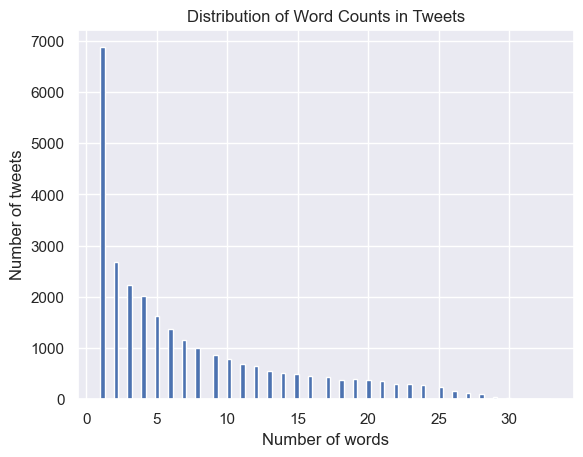

In [9]:
# Analyze the length distribution of tweets
# This helps us understand how long our input sequences should be

# TODO: Create a new column counting words in each tweet
df['word_count_selected'] = df['selected_text'].apply(lambda x: len(x.split()))

# Create a histogram to visualize word count distribution
df.word_count_selected.hist(bins=100)
plt.xlabel('Number of words')
plt.ylabel('Number of tweets')
plt.title('Distribution of Word Counts in Tweets')
plt.show()

# 💡 Hint: Use the split() method to count words in a sentence

In [10]:
# Get statistical summary of our dataset
# This shows us mean, median, and quartiles for word counts
df.describe()

,word_count_selected
count,27480.000000
mean,7.102511
std,6.891179
min,1.000000
25%,1.000000
50%,4.000000
75%,11.000000
max,33.000000


In [11]:
# Check the distribution of sentiment classes
# Important: This tells us if our dataset is balanced or imbalanced

# TODO: Count how many tweets belong to each sentiment category
df.sentiment.value_counts()

# 💡 Hint: Use value_counts() to count unique values in a column

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

In [12]:
# Convert text sentiment labels to numerical values
# Example: 'positive' → 2, 'neutral' → 1, 'negative' → 0

# TODO: Initialize LabelEncoder and transform the sentiment column
le = LabelEncoder()  # Create LabelEncoder object
df['sentiment'] = le.fit_transform(df['sentiment'])  # Transform sentiment labels to numbers

# Display sample data to see the transformation
df.sample(7)

# 💡 Hint: LabelEncoder() creates the encoder, and sentiment is the column name to transform

,textID,text,selected_text,sentiment,clean_text,word_count_selected
19747,2ee537aba8,Can`t wait to go to bed,Can`t wait to go to bed,2,` wait go bed,6
20637,a971eb9be0,"Would love it if you guys toured here, really...","Would love it if you guys toured here, really!...",1,would love guy tour really ! Philippines tour ?,11
17690,74be5dc362,So slpy 2day zzzz,So slpy 2day zzzz,1,slpy 2day zzzz,4
9276,1d201cb974,8 of my 11 followers are random spammers,spammers,0,8 11 follower random spammer,1
19593,7994a5c310,At nosely safari park with Leah,At nosely safari park with Leah,1,nosely safari park Leah,6
5207,f598225c27,"LOL she is okay, its just he songs are so cat...",its just he songs are so catchy,2,LOL okay song catchy get stuck head,7
15525,4a4c6608ec,going to funeral today for friend and classmat...,who died in a car wreck last Friday,0,go funeral today friend classmate die car wrec...,8


In [13]:
# Check the distribution after encoding - should be the same counts but with numbers
df.sentiment.value_counts()

sentiment
1    11117
2     8582
0     7781
Name: count, dtype: int64

In [14]:
# Save the label mapping for future reference
# This is crucial for interpreting model predictions later!

# TODO: Get the original class names from the label encoder
le.classes_  # View original class names before encoding
num_classes = len(le.classes_)

# Create a mapping dictionary: original label → encoded number
class_mapping = dict(zip(le.classes_, range(num_classes)))
print("Class mapping:", class_mapping)

# Save the mapping to a JSON file for later use
import json
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)

# 💡 Hint: The classes_ attribute stores the original class names

Class mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [15]:
# List all files in current directory to verify our mapping was saved
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Data Quality Check
**Always check for missing values before training!** Missing data can cause errors or poor model performance.

In [16]:
# TODO: Check for missing values in our dataset
df.isna().sum()  # Count missing values in each column

# 💡 Hint: Use isna() or isnull() to find missing values, then sum() to count them

textID                  0
text                    0
selected_text           0
sentiment               0
clean_text             31
word_count_selected     0
dtype: int64

In [17]:
# Examine rows with missing values to understand why they're missing
# This helps us decide how to handle them
df[df.isnull().any(axis=1)]

,textID,text,selected_text,sentiment,clean_text,word_count_selected
8,e050245fbd,Both of you,Both of you,1,NaN,3
640,5210cc55ae,no,no,1,NaN,1
1489,07e2fab0da,no its the same,no its the same,1,NaN,4
2041,12c89d051d,That was ****.,****.,0,NaN,1
3034,d497141ca8,me too,me too,1,NaN,2
3613,ec08321ce1,**** EM,**** EM,0,NaN,2
3674,f18b9435c8,with,with,1,NaN,1
5053,fd13a24d43,it does.,it does.,1,NaN,2
5154,3a4ff44f1a,i will do that..,i will do that..,1,NaN,4
8119,4a265d8a34,****,****,0,NaN,1


**Analysis:** These appear to be tweets that contained only stop words, which were removed during text cleaning, leaving empty strings.

In [18]:
# Handle missing values by removing them
# Since there are only 31 missing values out of thousands, dropping them is reasonable

# TODO: Remove rows with missing values
df.dropna(axis=0, inplace=True)

# 💡 Hint: Use dropna() to remove rows with missing values

In [19]:
# Check our final dataset size
print(f"Final dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.shape

Final dataset shape: 27449 rows, 6 columns


(27449, 6)

## Building LSTM Model

**What is LSTM?** Long Short-Term Memory networks are a type of neural network that can remember information for long periods, making them excellent for text analysis where word order and context matter.

In [21]:
# Prepare data for machine learning
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from joblib import dump

# TODO: Define features (X) and target variable (y)
X = df['text']  # The text we want to classify
y = df['sentiment']  # The sentiment labels

# Check unique values in the sentiment column
unique_sentiments = y.unique()
print("Unique Sentiments:", unique_sentiments)

# TODO: Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# 💡 Hint: X should be 'selected_text' and y should be 'sentiment'. Test size of 0.2 means 20% for testing

Unique Sentiments: [1 0 2]
Training set: 21959 samples
Testing set: 5490 samples


((21959,), (21959,), (5490,), (5490,))

In [22]:
# Look at a sample training text to understand our data
print("Sample tweet:", X_train.iloc[1])
X_train.iloc[1]

Sample tweet: My door looks naked   It makes my room feel bigger though.


'My door looks naked   It makes my room feel bigger though.'

## Text Tokenization

**Key Concept:** Neural networks need numerical input. Tokenization converts text to numbers:
- "I love this movie" → [5, 23, 8, 102]
- Each unique word gets a unique number

In [23]:
# Tokenize text: Convert words to numerical sequences
# num_words=20000 means we keep only the 20,000 most frequent words

# TODO: Create a tokenizer that keeps the top 20,000 most common words
tokenizer = Tokenizer(num_words=20000)

# Fit tokenizer on training data only (important: don't use test data!)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of numbers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(f"Type of sequences: {type(X_train_seq)}")
type(X_train_seq), type(X_test_seq)

# 💡 Hint: We typically use 20000 as a good balance between vocabulary size and computational efficiency

Type of sequences: <class 'list'>


(list, list)

In [24]:
# Compare original text with its tokenized version
print("Original text:", X_train.iloc[1])
print("Tokenized version:", X_train_seq[1])
X_train_seq[1]

Original text: My door looks naked   It makes my room feel bigger though.
Tokenized version: [5, 1019, 236, 2978, 6, 293, 5, 439, 111, 2092, 126]


[5, 1019, 236, 2978, 6, 293, 5, 439, 111, 2092, 126]

## Sequence Padding

**Key Concept:** Neural networks need fixed-size input. Since tweets have different lengths, we:
- Pad short tweets with zeros: [5, 23] → [5, 23, 0, 0, 0]
- Truncate long tweets: [1,2,3,4,5,6,7] → [1,2,3,4,5] (if maxlen=5)

In [25]:
# Pad sequences to ensure uniform input size
# maxlen=33 means all sequences will have exactly 33 elements
# padding='post' adds zeros at the end

# TODO: Pad sequences to length 33
X_train_pad = pad_sequences(X_train_seq, maxlen=33, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=33, padding='post')

print(f"Padded training shape: {X_train_pad.shape}")
print(f"Padded testing shape: {X_test_pad.shape}")
X_train_pad.shape, X_test_pad.shape

# 💡 Hint: We chose 33 based on the word count analysis - most tweets have ≤33 words

Padded training shape: (21959, 33)
Padded testing shape: (5490, 33)


((21959, 33), (5490, 33))

In [26]:
# Compare tokenized sequence with its padded version
print("Tokenized sequence:", X_train_seq[1])
print("Padded sequence:", X_train_pad[1])
X_train_pad[1]

Tokenized sequence: [5, 1019, 236, 2978, 6, 293, 5, 439, 111, 2092, 126]
Padded sequence: [   5 1019  236 2978    6  293    5  439  111 2092  126    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


array([   5, 1019,  236, 2978,    6,  293,    5,  439,  111, 2092,  126,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [27]:
# Count the number of classes for our model output layer
# TODO: Calculate number of unique sentiment classes
num_classes = len(unique_sentiments)
print(f"Number of classes: {num_classes}")
num_classes

# 💡 Hint: Use unique_sentiments variable we created earlier

Number of classes: 3


3

## LSTM Model Architecture

**Model Components:**
1. **Embedding Layer**: Converts word indices to dense vectors
2. **LSTM Layer**: Processes sequential information
3. **Dense Layers**: Final classification layers
4. **Dropout**: Prevents overfitting

### Parameter Selection Guide:

**Vocabulary Size**: Number of unique words + 1 (for padding)
- Get from tokenizer: `len(tokenizer.word_index) + 1`

**Embedding Dimensions**: 
- Small vocab (<5K): 50-100 dimensions
- Medium vocab (5K-20K): 100-200 dimensions
- Large vocab (>20K): 200-300 dimensions

**LSTM Units**: 
- Simple tasks: 64-128 units
- Complex tasks: 256-512 units

In [28]:
# Calculate vocabulary size from our fitted tokenizer
# +1 because index 0 is reserved for padding tokens

# TODO: Calculate vocabulary size from tokenizer
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size} words")
vocab_size

# 💡 Hint: The word_index attribute contains all unique words mapped to numbers

Vocabulary size: 23103 words


23103

In [29]:
# Import additional modules for advanced model features
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [30]:
# Get unique classes in training data for class weight calculation
classes = np.unique(y_train)
print("Classes in training data:", classes)
classes

Classes in training data: [0 1 2]


array([0, 1, 2])

In [31]:
# Look at a sample label
print("Sample label:", y_train.iloc[0])
y_train.iloc[0]

Sample label: 0


np.int64(0)

## Handling Class Imbalance

**Why Class Weights?** If we have 1000 positive tweets but only 100 negative tweets, our model might just predict "positive" for everything and get 90% accuracy! Class weights help balance this by giving more importance to underrepresented classes.

In [32]:
# **OPTIONAL SECTION** - Compute class weights to handle imbalanced data
# This gives more weight to underrepresented classes during training

cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
print(f"Class weights type: {type(cw)}")
type(cw)

Class weights type: <class 'numpy.ndarray'>


numpy.ndarray

In [33]:
# Display computed class weights
print("Computed class weights:", cw)
cw

Computed class weights: [1.17774202 0.82698753 1.06189854]


array([1.17774202, 0.82698753, 1.06189854])

In [34]:
# **OPTIONAL SECTION** - Create class weight dictionary for Keras
# Convert numpy array to dictionary format required by Keras

class_weight = {int(cls): float(w) for cls, w in zip(classes, cw)}
print("Class weight dictionary:")
class_weight

Class weight dictionary:


{0: 1.1777420219898096, 1: 0.8269875343652318, 2: 1.0618985444170415}

In [35]:
# Get sequence length for our model input layer
sequence_length = X_train_pad.shape[1]
print(f"Sequence length: {sequence_length}")
sequence_length

Sequence length: 33


33

In [36]:
import keras

# Build the LSTM model architecture

# TODO: Complete the model architecture
lstm_model = Sequential([
    # Embedding layer: converts word indices to dense vectors
    Embedding(input_dim=vocab_size,  # vocabulary size
              output_dim=100,  # embedding dimension (100 is good for medium vocab)
              input_length=sequence_length  # length of input sequences
              ),
    
    # Bidirectional LSTM: processes text in both forward and backward directions
    Bidirectional(LSTM(256,  # 256 LSTM units
                       return_sequences=False,  # only return final output
                       dropout=0.3,  # prevent overfitting
                       recurrent_dropout=0.3,  # dropout for recurrent connections
                       kernel_regularizer=keras.regularizers.l2(0.001)  # L2 regularization
                       )),
    
    # Dense layer for feature learning
    Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    Dropout(0.6),  # High dropout to prevent overfitting
    
    # Output layer: number of neurons = number of classes
    Dense(3, activation='softmax')  # softmax for multi-class classification
])

# Compile the model with optimizer, loss function, and metrics
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate
    loss='sparse_categorical_crossentropy',  # loss function for integer labels
    metrics=['accuracy']
)

# Display model architecture
lstm_model.summary()

# 💡 Hint: input_dim should be vocab_size, and Dense output should be num_classes

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Model Training

**Training Process:**
1. **EarlyStopping**: Stops training if validation loss stops improving
2. **ReduceLROnPlateau**: Reduces learning rate when training plateaus
3. **Validation Split**: Uses 20% of training data for validation
4. **Class Weights**: Balances the impact of different sentiment classes

In [37]:
# Set up training callbacks for better training control

# EarlyStopping: stops training if validation loss doesn't improve for 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ReduceLROnPlateau: reduces learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Convert labels to numpy array for compatibility
y_train_np = np.asarray(y_train).astype('int32')

# Train the model with GPU acceleration
# TODO: Complete the training configuration
with tf.device(device_name):  # Use GPU device
    h2 = lstm_model.fit(
        X_train_pad,  # Training features (padded sequences)
        y_train,  # Training labels
        epochs=12,  # Number of training epochs
        batch_size=128,  # Number of samples per batch
        validation_split=0.2,  # Use 20% of training data for validation
        callbacks=[early_stop, reduce_lr],  # Training callbacks
        class_weight=class_weight  # Apply class weights for balanced training
    )

# 💡 Hint: Use y_train for training labels and 0.2 for validation_split (20%)

Epoch 1/12
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.4638 - loss: 1.1166 - val_accuracy: 0.5421 - val_loss: 0.9283 - learning_rate: 0.0010
Epoch 2/12
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.6310 - loss: 0.8364 - val_accuracy: 0.6421 - val_loss: 0.8293 - learning_rate: 0.0010
Epoch 3/12
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.7438 - loss: 0.6598 - val_accuracy: 0.6687 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 4/12
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8091 - loss: 0.5357
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.8065 - loss: 0.5492 - val_accuracy: 0.6719 - val_loss: 0.8441 - learning_rate: 0.0010
Epoch 5/12
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8553 - loss: 0.4564
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.8548 

In [38]:
# Helper function for plotting learning curves
# This helps us visualize how well our model learned over time

def plot_learning_curve(hist):
    """Plot training and validation accuracy over epochs"""
    plt.figure(figsize=(5, 4))

    # Extract accuracy data from training history
    train = hist.history['accuracy']
    val = hist.history['val_accuracy']
    epochs_run = range(1, len(train) + 1)

    # Create DataFrames for plotting
    train_temp = pd.DataFrame({"Epochs": epochs_run, "Training Accuracy": train})
    val_temp = pd.DataFrame({"Epochs": epochs_run, "Validation Accuracy": val})

    # Plot both curves
    sns.lineplot(data=train_temp, x='Epochs', y='Training Accuracy', 
                marker='o', color='coral', label='Training Accuracy')
    sns.lineplot(data=val_temp, x='Epochs', y='Validation Accuracy', 
                marker='>', color='green', label='Validation Accuracy')

    plt.title("Model Performance: Accuracy vs. Epochs", fontsize=16)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

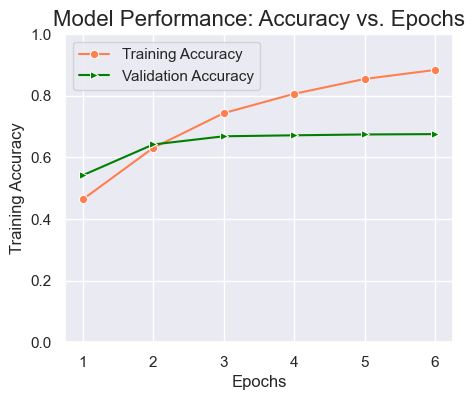

In [39]:
# Plot the learning curves to analyze training performance
# This helps us understand if the model is learning properly

# TODO: Plot the learning curve using our training history
plot_learning_curve(h2)

# 💡 Hint: Use the training history object 'h2' that was returned from model.fit()

## Model Evaluation

**Understanding the Learning Curve:**
- **Good fit**: Training and validation accuracy are close and both improving
- **Overfitting**: Training accuracy much higher than validation accuracy
- **Underfitting**: Both accuracies are low and not improving

In [40]:
# Evaluate the model on test data (data the model has never seen!)
# This gives us the true performance of our model

# TODO: Evaluate the model on test data
loss, acc = lstm_model.evaluate(X_test_pad, y_test)
print(f"Testing Accuracy: {acc*100:.2f}%")

# 💡 Hint: Use X_test_pad (the padded test sequences) for evaluation

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6678 - loss: 0.8108
Testing Accuracy: 66.78%


## Model Deployment Preparation

**Why Save Models?** 
- **Model file (.keras)**: Contains the trained neural network
- **Tokenizer file (.joblib)**: Contains the word-to-number mapping
- **Class mapping (.json)**: Maps numbers back to sentiment labels

All three files are needed to make predictions on new tweets!

In [41]:
# Save the trained model and preprocessing components for future use

# TODO: Save the trained model and tokenizer
lstm_model.save('sentiment_lstm_model.keras')  # Save the neural network
dump(tokenizer, 'tokenizer.joblib')  # Save the tokenizer for text preprocessing

print("✅ Model and tokenizer saved successfully!")
print("Files saved:")
print("- sentiment_lstm_model.keras (the trained model)")
print("- tokenizer.joblib (text preprocessing)")
print("- class_mapping.json (label mapping)")

# 💡 Hint: Model files use .keras extension, and tokenizer variable should be saved

✅ Model and tokenizer saved successfully!
Files saved:
- sentiment_lstm_model.keras (the trained model)
- tokenizer.joblib (text preprocessing)
- class_mapping.json (label mapping)


In [42]:
# Verify all required files have been created
!ls -la *.keras *.joblib *.json

print("\n🎉 Congratulations! You've successfully built and trained an LSTM model for sentiment analysis!")
print("\n📊 Summary of what you accomplished:")
print(f"- Processed {df.shape[0]} tweets")
print(f"- Built vocabulary of {vocab_size} unique words")
print(f"- Achieved {acc*100:.2f}% accuracy on test data")
print(f"- Saved model ready for deployment")


🎉 Congratulations! You've successfully built and trained an LSTM model for sentiment analysis!

📊 Summary of what you accomplished:
- Processed 27449 tweets
- Built vocabulary of 23103 unique words
- Achieved 66.78% accuracy on test data
- Saved model ready for deployment


'ls' is not recognized as an internal or external command,
operable program or batch file.
